In [2]:
#!pip install import-ipynb
#!pip install mpl-finance

import import_ipynb 
import get_data as get 

import import_ipynb 
import returns as ret

In [19]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os 
import pandas_datareader as web
from time import time
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.dates as mdates 
import pylab
import numba as nb

#%matplotlib inline

$$ E_i = \sum_{j=1}^{\text{train_length}}\left(\frac{sim_j^i - y_j}{y_j}\right) \quad \quad i=1,.....,\text{train_length}$$


FB data already saved in stock_dfs.
Building graph for FB....

The index of the minumum error is: 24



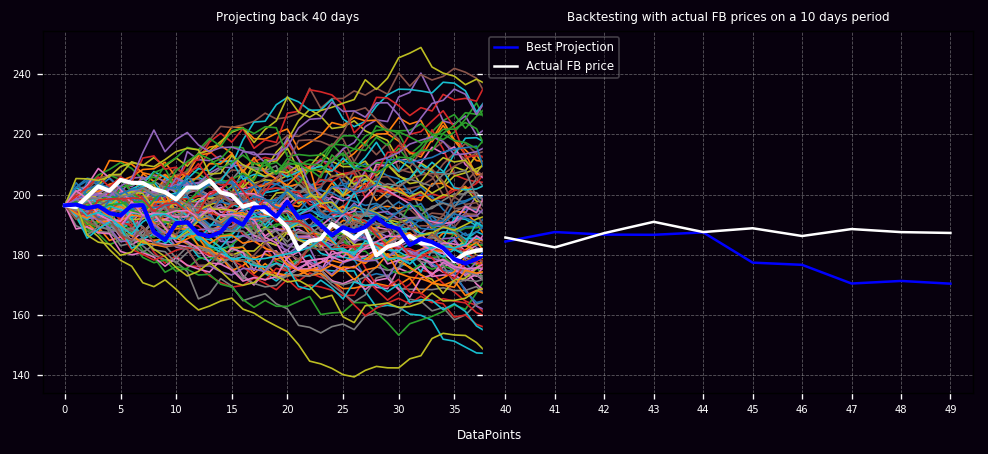

Last 10 terms of Best_estimator of future FB price is:

      Adj Close          24
40  185.669998  184.328707
41  182.389999  187.493060
42  187.139999  186.638380
43  190.899994  186.575454
44  187.490005  187.382271
45  188.759995  177.298594
46  186.169998  176.568069
47  188.490005  170.341949
48  187.470001  171.195928
49  187.190002  170.287218

First 20 errors are displayed below:

 [ 0.73069401  0.45870632  2.20730861  1.53268863  0.48398725  0.96090445
 -0.44339516  0.9692243   1.41821459 -1.60736434 -0.30455695  0.00846733
  0.17078681 -0.85096413 -0.40382262  1.46311495  0.16931359 -1.09913208
 -1.83179295  0.19379495]

Duration in Seconds:   0.824


In [108]:
def monteCarlo(ticker,noOfSims = 500,IterPerSim = 50,
               years=5,size = 2/3,verbose = True,plot = True):
    
    '''Carries out 500 Simulations (by default) with 50 datapoints in each simulation. 
    I assume that stock price is log-normally distributed and pick by random fluctuations 
    (i.e. brownian random variable) accordingly. 
    
    When calculating the Error, I am only looking back 10 days from the end of train_length as 
    more historic data doesn't affect the future price (by markov property)
    
    Parameter:
    ==============
    ticker: string
        stock ticker to look up a stock on yahoo api
    noOfSims: integer
        no. of simulations which is set to 500 as default
    IterPerSims: integer
        no. of datapoints per simulation
    years: integer
        some excess parameter which I need to remove as it is not necessary
    size: float 
        what proportion of my data, do I want to be training data
    verbose: boolean
        if my years>10, then if False, the graph will print everything it has
        for the prices.
    plot: boolean
        if True, graphs are plotted 
    
    '''
    
    if years>10 and verbose: 
        print('''In get_data() method, I have only extracted data for the last 10 years, 
        please change the above method for more historic data\nIf you would like to see all the prices plot, 
        then make verbose = False''')
 
   ######## sorting out the data so that code is efficient and doesn't reload when not necessary ################  
    else:
        if os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                         parse_dates=True,index_col=0)

            if not {'Returns'}.issubset(data.columns): 
                ret.returns(ticker)
                data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                     parse_dates=True,index_col=0) 
                print('Adding relative column to existing {}.csv file'.format(ticker))

            else:
                print('')
                print('{} data already saved in stock_dfs.'.format(ticker))

        else: 
            ret.returns(ticker)
            data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                     parse_dates=True,index_col=0)
            print('{} data now saved in stock_dfs folder. \n'.format(ticker))

        print('Building graph for {}....\n'.format(ticker))

        
        
        ########################### The Monte Carlo Simulations ############################################
        df_close = data['Adj Close'][-IterPerSim:]
        returns = data['Returns'][-IterPerSim:]
    
            
        log_returns = np.log(1+returns)  #represents log(S(t+dt)/S(t))
        log_mean = log_returns.mean()    #\mu of log-returns 
        log_var = log_returns.var()      #\sigma^2 of log-returns
        log_std = log_returns.std()      
        
        drift = log_mean - (0.5*log_var)
        Z = norm.ppf(np.random.uniform(0,1,(IterPerSim,noOfSims)))
        
        daily_returns = np.exp(drift+log_std*Z)
       
        price_list = np.zeros_like(daily_returns)
        start_price = df_close[0]
        price_list[0] = start_price
        
        for i in range(1,IterPerSim):
            price_list[i] = price_list[i-1]*daily_returns[i]
        
        #price_list = pd.DataFrame(price_list,index = df_close.index) 
        price_list = pd.DataFrame(price_list) 
        
        train_length = int(size*IterPerSim)
        test_length = IterPerSim - train_length
        
        Error = np.zeros((noOfSims))
        #weights = np.zeros((train_length))
        
        for i in range(noOfSims): #only looking back 10 days
            Error[i] = np.sum((np.divide(price_list[i][train_length-10:train_length]-df_close.values[train_length-10:train_length],df_close.values[train_length-10:train_length])))
            #Error[i] = weights@(np.divide(price_list[i][:train_length]-df_close.values[:train_length],df_close.values[:train_length]))
            
        small_index = np.argmin(np.abs(Error))
        print('The index of the minumum error is: {}\n'.format(small_index),sep='\n')
        
        best_estimator = price_list[small_index]
        #print(type(best_estimator))
        
        ################################
        
        ##################### Plot to see my results if plot = True ######################################################
        if plot:
            
            datelist = df_close.index
            #print(datelist)
            #plt.style.use('ggplot')
            
            mpl.rcParams.update({'axes.facecolor':'#07000d','font.size':6}) 
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4),sharey=True, dpi=120,facecolor='#07000d',gridspec_kw = {'wspace':-0.1, 'hspace':-1.5})
            
            
            #plt.figure(figsize=(12,5),)
            #ax1 = plt.subplot2grid((6,8),(0,0),rowspan = 6, colspan = 4,facecolor='#07000d')
            ax1.plot(price_list[:train_length+1],linewidth=1)
            ax1.plot(df_close.values[:train_length+1],linewidth=2.5,color='w')
            ax1.plot(best_estimator[:train_length+1],linewidth=2.5,color='b')
            #ax1.set_xlabel("Date",color= 'w')
            #ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))
            ax1.grid(linestyle='--', linewidth=0.5,alpha=0.5)
            ax1.xaxis.set_ticks(np.arange(0,train_length,step=5))
            ax1.set_title('Projecting back {} days'.format(train_length),color='w')
            
            
            ax1.tick_params(colors='w')
            ax1.spines['right'].set_color('#07000d')
            
            #plt.figure(figsize=(11,8),facecolor='#07000d')
            X = np.arange(train_length,IterPerSim)
            #ax2 = plt.subplot2grid((6,8),(0,0),rowspan = 6, colspan = 4,facecolor='#07000d')
            ax2.plot(X,best_estimator[train_length:],linewidth=1.5,color='b',label='Best Projection')
            ax2.plot(X,df_close.values[train_length:],linewidth=1.5,color='w',label = 'Actual {} price'.format(ticker))
            ax2.tick_params(colors='w')
            ax2.xaxis.set_ticks(np.arange(train_length,IterPerSim,step=1))
            ax2.grid(linestyle='--', linewidth=0.5,alpha=0.5)
            ax2.spines['left'].set_color('#07000d')
            ax2.set_title('Backtesting with actual {} prices on a {} days period'.format(ticker,test_length),color='w')
            plt.tight_layout()
            
            
            ax2.legend()
        
            maLeg = ax2.legend(loc = 2, ncol = 1, prop={'size':7},fancybox = True)  #loc = 4, prop={'size':7},fancybox = True
            maLeg.get_frame().set_alpha(0.3) #set the background of legend to shade
            textEd = pylab.gca().get_legend().get_texts()
            pylab.setp(textEd[0:5],color = 'w') #changing the colour of legend to white
            #plt.xticks(rotation=20)
            
            plt.figtext(0.47, 0.030, 'DataPoints',color='w',fontsize='large')

            plt.show()
        
        return best_estimator,Error,df_close
        

if __name__=="__main__":
    t0 = time()
    ticker = 'FB'
    best_estimator,e,df_close = monteCarlo(ticker,noOfSims = 100,IterPerSim = 50,size = 0.8,plot = True,verbose = True)
    df = pd.DataFrame(df_close)

    df.reset_index(inplace=True, drop=True) #remove index from dates to numbers
    
    df = df.join(best_estimator,how='left') #uses the index of dataframe on the left (i.e. df_close)
    timed = time() - t0
    print('Last 10 terms of Best_estimator of future {} price is:\n\n {}'.format(ticker,df.tail(10)),'','First 20 errors are displayed below:\n\n {}'.format(e[:20]),'',sep='\n')
    print('Duration in Seconds: %7.3f' % timed)

In [12]:
def monteCarlo_strat1(ticker,noOfSims = 500,noOfDays = 50,years = 3, months = 0, 
               days = 0,verbose = True):
    
    if years>10 and verbose: 
        print('''In get_data() method, I have only extracted data for the last 10 years, 
        please change the above method for more historic data\nIf you would like to see all the prices plot, 
        then make verbose = False''')
 
   ######## sorting out the data so that code is efficient and doesn't reload when not necessary ################  
    else:
        if os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                         parse_dates=True,index_col=0)

            if ('Returns') not in data.columns: 
                ret.returns(ticker)
                data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                     parse_dates=True,index_col=0) 
                print('Adding relative column to existing {}.csv file'.format(ticker))

            else:
                print('')
                print('{} data already saved in stock_dfs.'.format(ticker))

        else: 
            ret.returns(ticker)
            data = pd.read_csv('stock_dfs/{}.csv'.format(ticker),
                     parse_dates=True,index_col=0)
            print('{} data now saved in stock_dfs folder. \n'.format(ticker))

        print('Building graph for {}....\n'.format(ticker))

        ###################

        ############ filtering data for timeperiod specified by the user ####################################
        df = get.specified_prices(data,years=years,months=months,days=days)
        df_close = df['Adj Close']
        returns = df['Returns']
        last_price = df_close[-1]
        
        vol = returns.std()
        
        Sims = np.zeros((noOfDays+1,noOfSims))  #creates a matrix
        Sims[0] = last_price

        for i in range(1,noOfDays+1):
            z = 1+np.random.normal(0,vol,noOfSims)
            Sims[i] = Sims[i-1]*z
        
        return Sims

if __name__=="__main__":
    t0 = time()
    ticker = 'TWTR'
    data = monteCarlo_strat1(ticker,noOfSims = 500,noOfDays = 50,years = 3, months = 0, 
                   days = 0,verbose = True)
    timed = time() - t0
    print(data,'',sep='\n')
    print('Duration in Seconds: %7.3f' % timed)


TWTR data already saved in stock_dfs.
Building graph for TWTR....

[[44.25999832 44.25999832 44.25999832 ... 44.25999832 44.25999832
  44.25999832]
 [43.93352551 43.54728412 44.37714617 ... 43.99729859 45.27789321
  43.95938935]
 [42.66599048 41.9839059  41.61453087 ... 44.2388162  44.58272144
  42.15670131]
 ...
 [47.32989175 40.36591774 44.47939105 ... 38.8064723  71.98449685
  48.77005535]
 [50.43746761 39.50520891 45.71657307 ... 39.7210448  68.63844098
  50.25328327]
 [50.60589598 37.39131422 47.23935868 ... 42.05348974 68.31737425
  48.75648284]]

Duration in Seconds:   0.016


0.0431223361055925
Duration in Seconds   0.488


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


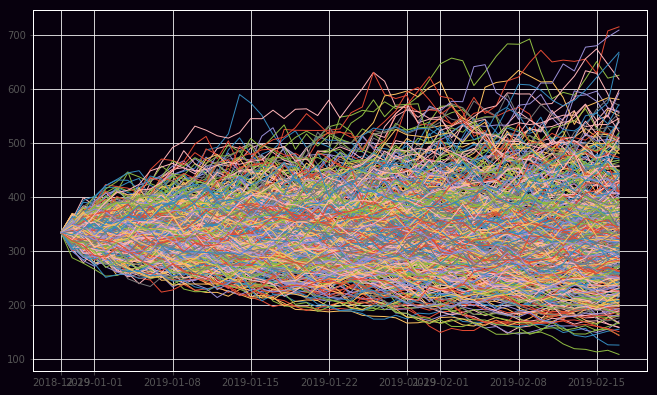

2019-02-17 00:00:00
Date
2018-12-31    332.799988
2019-01-02    310.119995
2019-01-03    300.359985
2019-01-04    317.690002
2019-01-07    334.959991
Name: Close, dtype: float64
[333.86999512 328.82270067 348.9558266  376.95465647 400.4199611
 416.27883444 426.61075122 434.19229016 399.00289107 418.77935653
 440.02808727 447.45454202 453.19768813 486.8940917  491.73536354
 516.76038187 589.72001163 573.98598616 551.28998115 515.29318066
 488.70625412 475.04347458 455.29114588 392.00338746 366.66184381
 367.26724193 376.07175689 369.15359622 363.92219771 352.80434348
 381.62900457 397.58949627 391.52093654 368.1122174  364.763564
 388.17103941 361.01038432 380.48040362 376.25102847 366.95378486
 378.73010851 362.87774653 381.18657332 402.35724648 403.95663753
 406.68010562 434.599923   450.16620614 479.3095154  466.03086002
 517.1761526 ]


In [18]:
t0 = time()


start = dt.datetime(2018,6,29)
end = dt.datetime(2018,12,29)

stock = 'TSLA'
prices = web.DataReader(stock,'yahoo',start,end)['Close']
returns = prices.pct_change(1)
last_price = prices[-1];

noOfSims = 500;
noOfDays = 50

vol = returns.std()
Sims = np.zeros((noOfDays+1,noOfSims))
Sims[0] = last_price
print(vol)

for i in range(1,noOfDays+1):
    z = 1+np.random.normal(0,vol,noOfSims)
    Sims[i] = Sims[i-1]*z

time = time() - t0
print('Duration in Seconds %7.3f' % time)

######################################################################################
datelist = pd.date_range(end, periods=noOfDays+1).tolist()

plt.style.use('ggplot')
plt.figure(figsize=(11,8),facecolor='#07000d')
ax1 = plt.subplot2grid((6,1),(1,0),rowspan = 6, colspan = 1,facecolor='#07000d')
ax1.plot(datelist,Sims,linewidth=1)
plt.show()

test_end = dt.datetime(2018,12,29)+dt.timedelta(days=noOfDays)
print(test_end)
test_prices = web.DataReader(stock,'yahoo',end,test_end)['Close']
print(test_prices.head())
print(Sims[:,1])


In [8]:
a = pd.DataFrame([0,1,4,6,8,9])
b = pd.DataFrame([1,-4,7,9,5,6])
c = a*b.shift(1)
c

,0
0,NaN
1,1.0
2,-16.0
3,42.0
4,72.0
5,45.0
